## Instructions {-}

1. This template serves as the required format for your code and report submission for the Prediction Problem assignment.
2. You may modify the template to improve readability or add relevant details, but it must include all requested information.
3. Ensure that your work is reproducible, meaning your code should consistently yield a metric value close to your Kaggle leaderboard score despite inherent randomness in data science.

## Reading data & Importing Libraries

In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import recall_score, accuracy_score, roc_curve, roc_auc_score, confusion_matrix
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

X_train = pd.read_csv('../data/prediction_problem/train_X.csv')
y_train = pd.read_csv('../data/prediction_problem/train_y.csv')
sample_submission = pd.read_csv('../data/prediction_problem/sample_submission.csv')
public_private_X = pd.read_csv('../data/prediction_problem/public_private_X.csv')

## 1) Exploratory Data Analysis (EDA)

* Summarize key insights obtained from the dataset.
* Discuss trends, correlations, or anomalies that influenced your modeling decisions.
* Provide relevant data visualizations (e.g., histograms, scatter plots, correlation matrices) to support your findings.

*To start, I began by running a correlation matrix of all numeric variables in the data to see if any were particularly correlated with our response variable (see below). Though this didn't reveal any overtly strong cases for feature creation, I did note that there were a few variables that I considered discarding at this stage, like transit lead time, purchasing lead time, and days between order and due date. However, these seem like they'd be objectively valuable data points given the nature of the problem, so I decided to keep them in for now to further explore.*

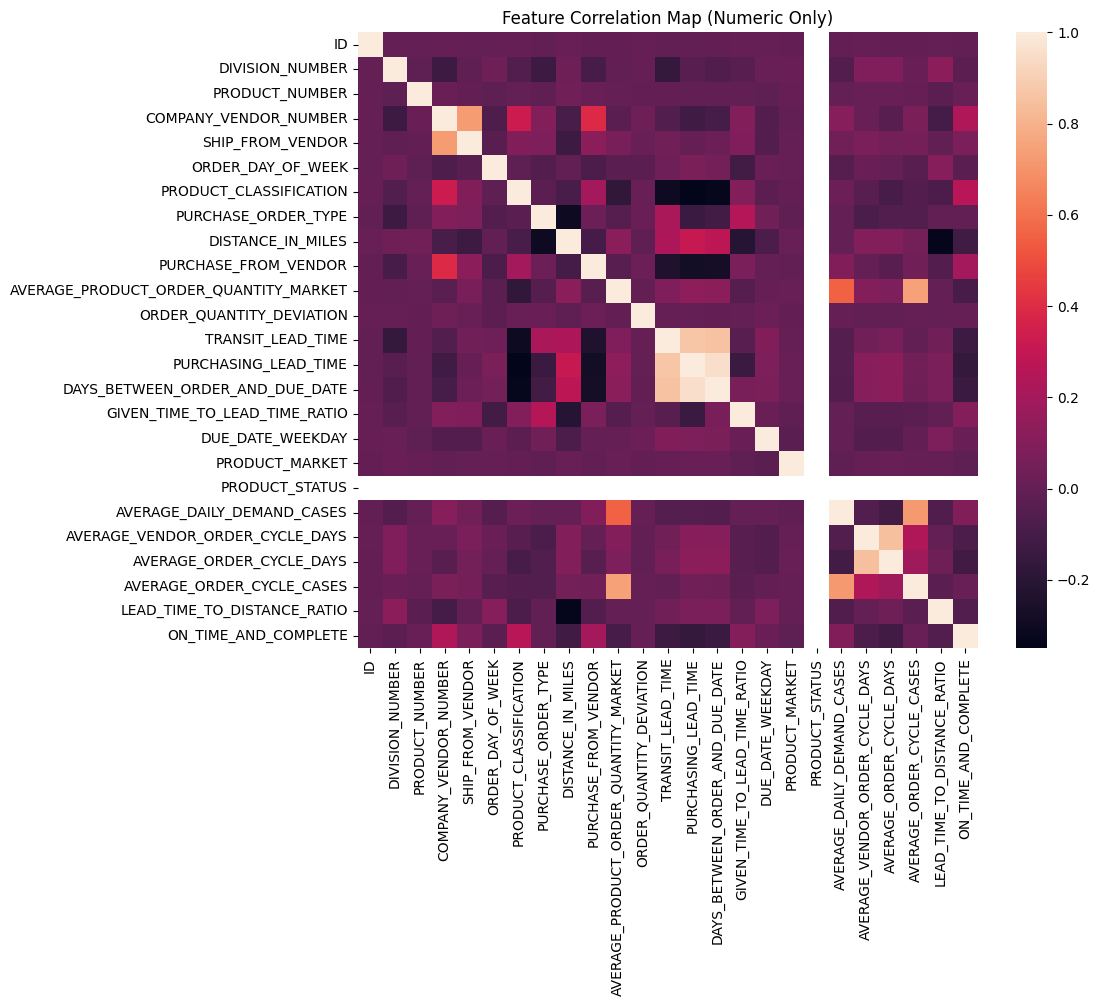

In [191]:
# Splitting into numeric and categorical/other features
num_X_train = X_train.select_dtypes(include = 'number')
cat_X_train = X_train.select_dtypes(exclude = 'number')

# Merging data for correlations between predictors and response
merged_numeric_xy = num_X_train.merge(y_train, on = 'ID')

# Plotting correlation heatmap
plt.figure(figsize = (10,8))
sns.heatmap(merged_numeric_xy.corr(), annot = False, fmt = '.2f')
plt.title('Feature Correlation Map (Numeric Only)')
plt.show()

*To learn more about some specific points of interest (like those 3 mentioned above) I decided to create scatter plots between those and the response variable to see if I could discern any relationships*

/var/folders/0h/rn55jh3j4k3877bdp0_d3d1h0000gn/T/ipykernel_96413/816770922.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = merged_numeric_xy.groupby('bin').agg({


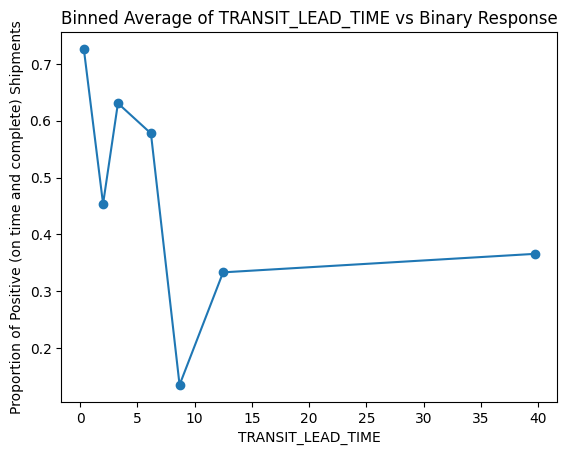

/var/folders/0h/rn55jh3j4k3877bdp0_d3d1h0000gn/T/ipykernel_96413/816770922.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = merged_numeric_xy.groupby('bin').agg({


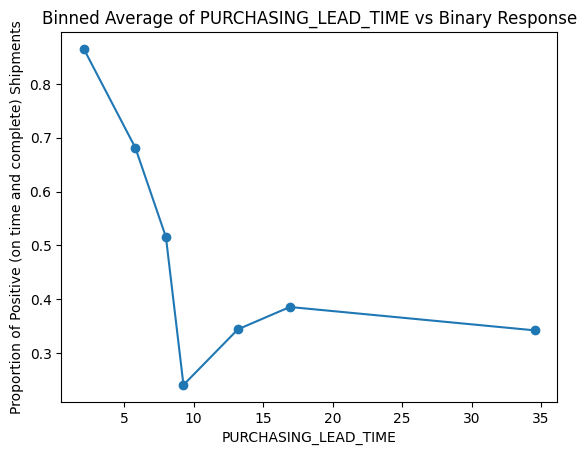

/var/folders/0h/rn55jh3j4k3877bdp0_d3d1h0000gn/T/ipykernel_96413/816770922.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = merged_numeric_xy.groupby('bin').agg({


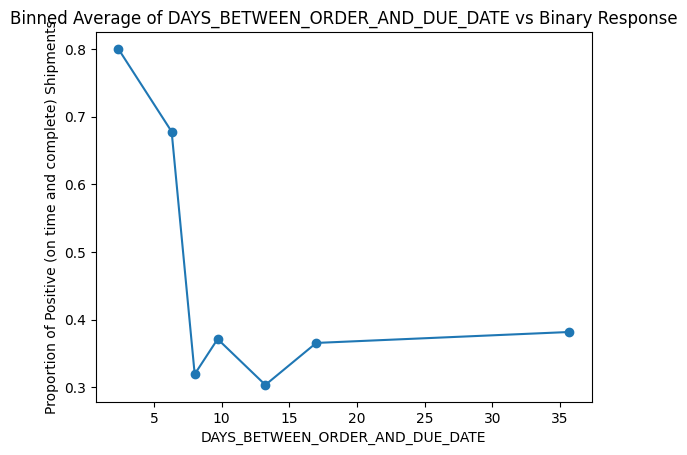

/var/folders/0h/rn55jh3j4k3877bdp0_d3d1h0000gn/T/ipykernel_96413/816770922.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = merged_numeric_xy.groupby('bin').agg({


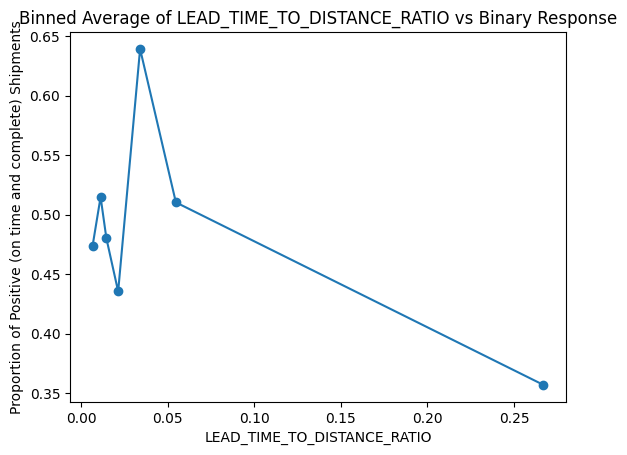

In [192]:
# Creating scatterplots

features = ['TRANSIT_LEAD_TIME', 'PURCHASING_LEAD_TIME', 'DAYS_BETWEEN_ORDER_AND_DUE_DATE', 'LEAD_TIME_TO_DISTANCE_RATIO']

for feature in features:
    # Create bins for the current predictor
    merged_numeric_xy['bin'] = pd.qcut(merged_numeric_xy[feature], q=7)
    
    # Calculate bin statistics: mean of the predictor and mean of the binary response
    bin_stats = merged_numeric_xy.groupby('bin').agg({
        feature: 'mean',
        'ON_TIME_AND_COMPLETE': ['mean', 'count']
    }).reset_index()
    bin_stats.columns = ['bin', 'pred_mean', 'response_mean', 'count']

    # Plot with dynamic labels
    plt.errorbar(x=bin_stats['pred_mean'], y=bin_stats['response_mean'],
                 fmt='o-', capsize=5)
    plt.xlabel(feature)  # Dynamic x-axis label
    plt.ylabel('Proportion of Positive (on time and complete) Shipments')
    plt.title(f'Binned Average of {feature} vs Binary Response')  # Dynamic title
    plt.show()


These graphs above showed an interesting relationship; I binned the three variables of interest and then plotting them against the average value of the response in the respective bins; it appears that lead times and days between order and due date seem to have a generally negative relationship with the response. Could this be due to a different type of order? (i.e. small orders to pick-up orders skewing the data) or is this a genuine relationship?

TypeError: Invalid object type at position 0

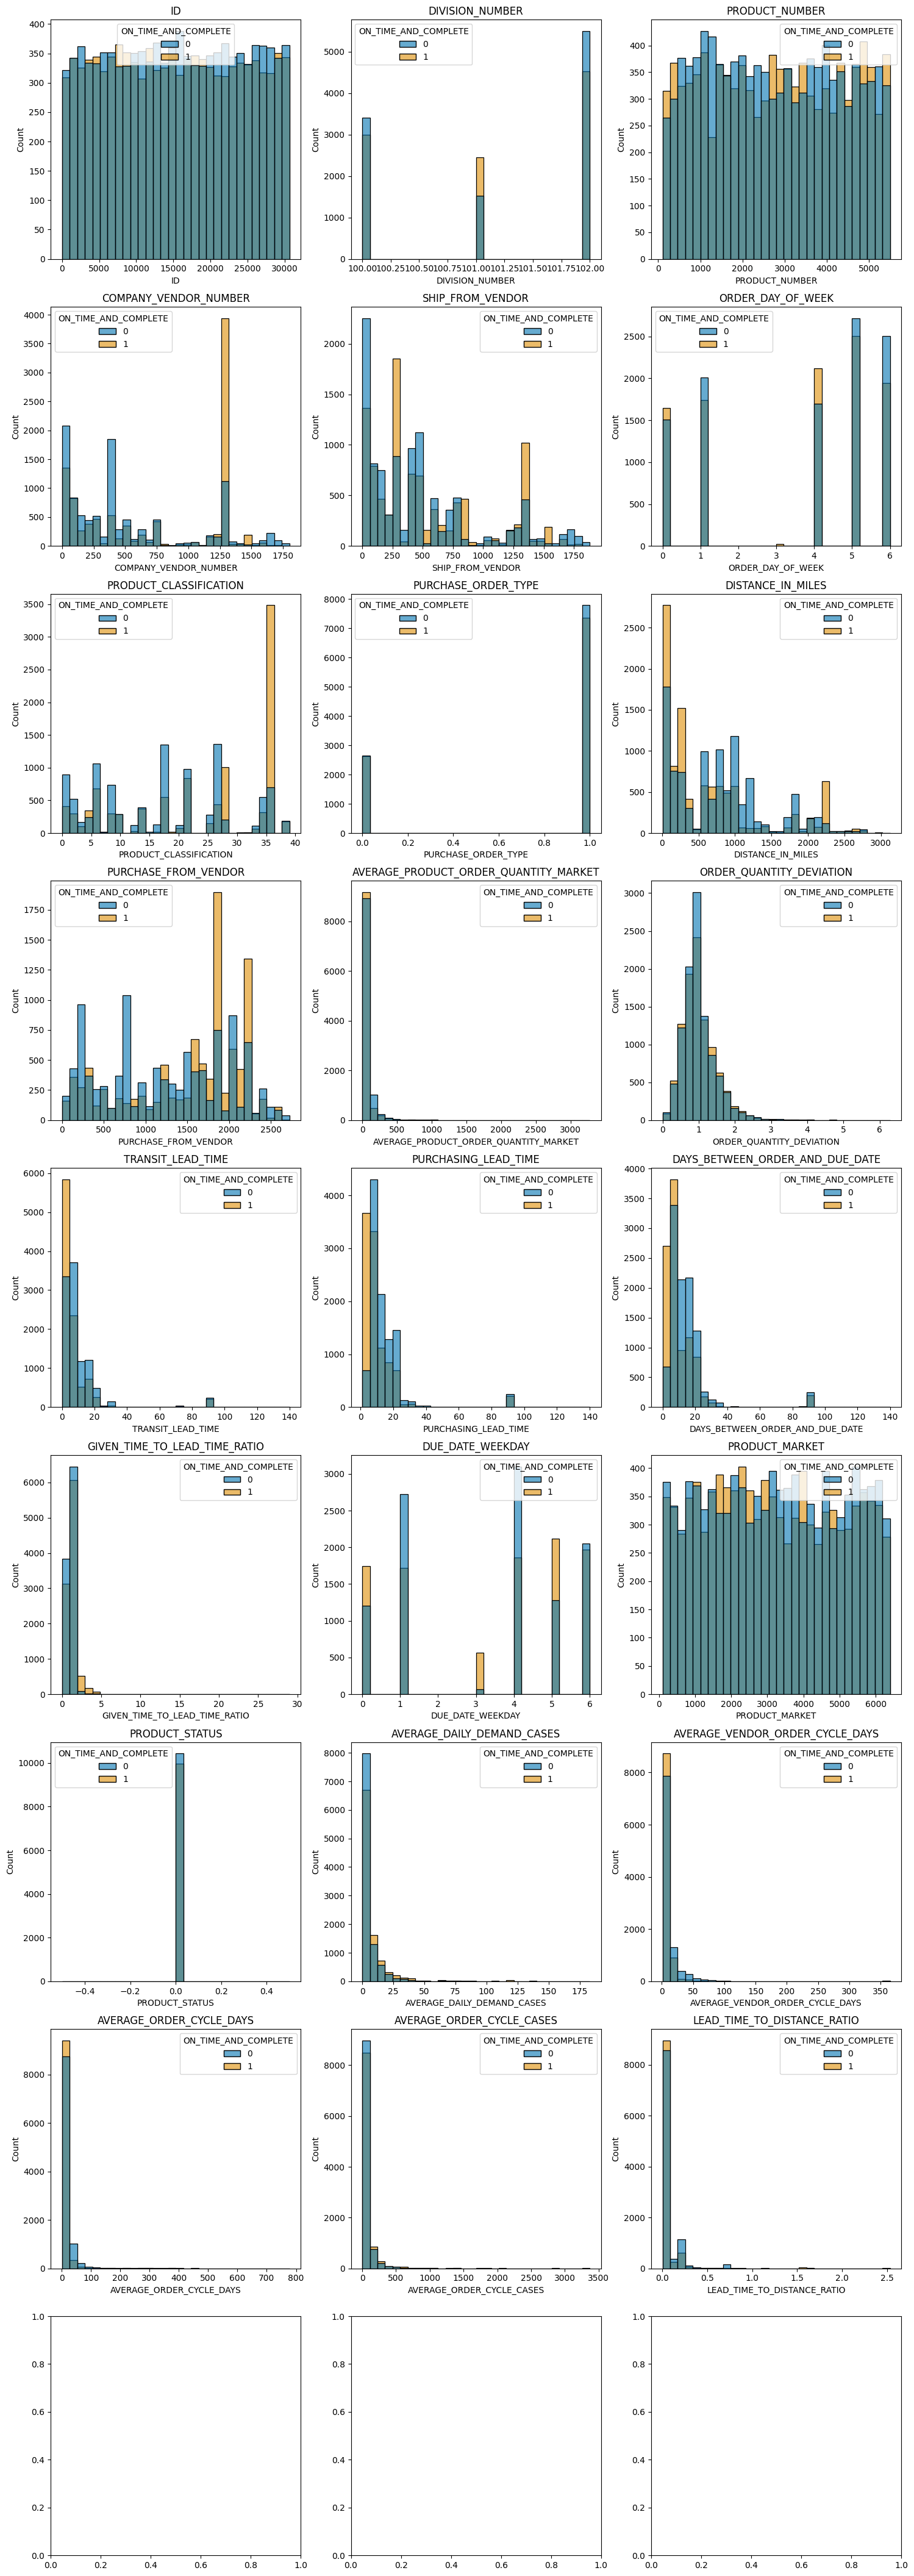

In [203]:
# Exploring skewness of numerical data off the suspician of right-tailed skew
import math
sns.set_palette('colorblind')

# Exclude the target column if needed
features = [col for col in merged_numeric_xy.columns if col != 'ON_TIME_AND_COMPLETE']

n_features = len(features)
n_cols = 3  # desired number of columns
n_rows = math.ceil(n_features / n_cols)  # ensure enough rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 6 * n_rows))
axes = axes.flatten()  # flatten for easy indexing

for idx, feature in enumerate(features):
    sns.histplot(data=merged_numeric_xy, x=feature, hue='ON_TIME_AND_COMPLETE',
                 bins=30, alpha=0.6, ax=axes[idx])
    axes[idx].set_title(feature)

# Hide any unused subplots
for j in range(len(features), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


*I see a right-tailed skew in the data, and will consider a log transformation on these values*

TypeError: Invalid object type at position 0

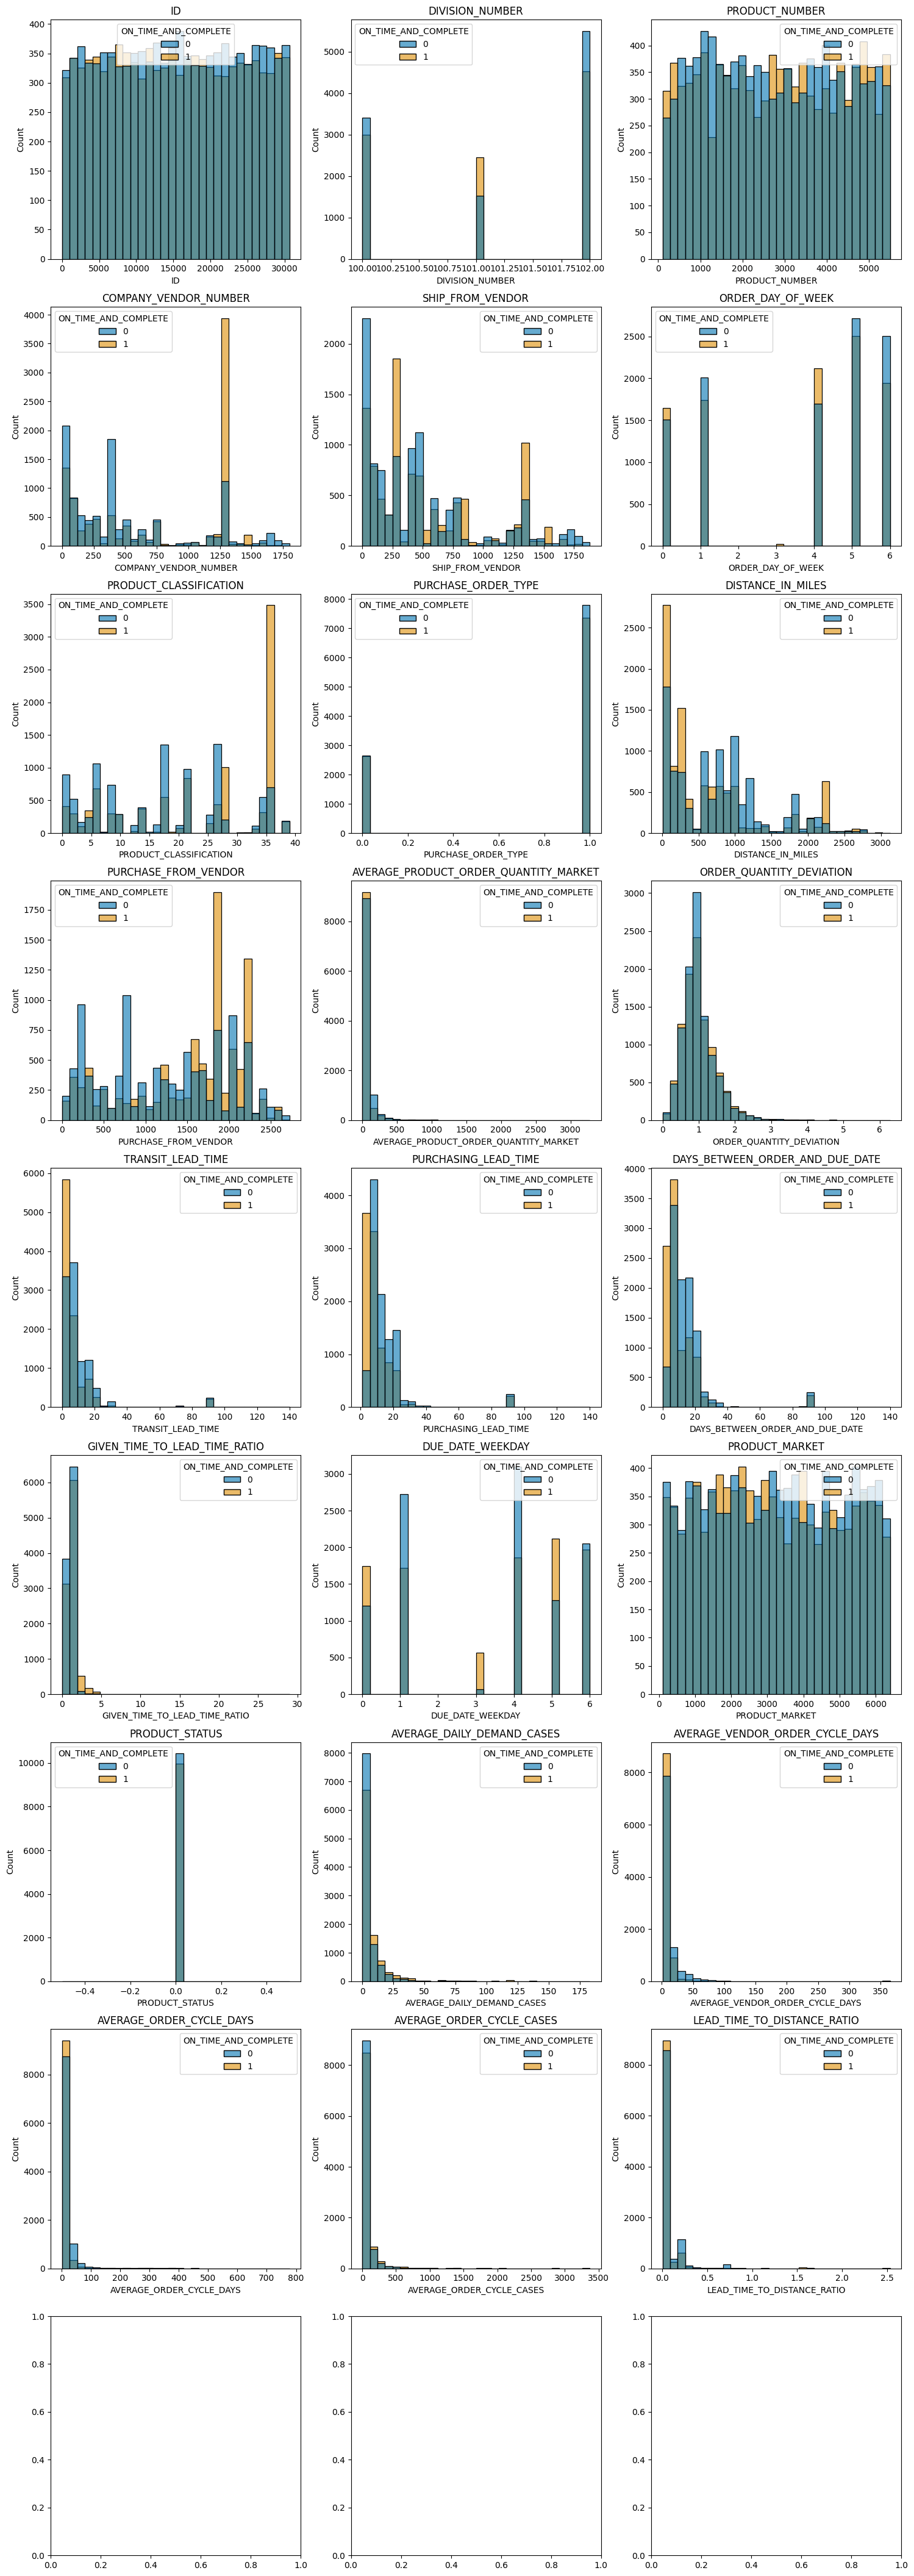

In [199]:
sns.set_palette('colorblind')

# Exclude  response variable
features = [col for col in merged_numeric_xy.columns if col != 'ON_TIME_AND_COMPLETE']
n_features = len(features)
n_cols = 3 
n_rows = math.ceil(n_features / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 6 * n_rows))
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.histplot(data=merged_numeric_xy, x=feature, hue='ON_TIME_AND_COMPLETE',
                 bins=30, alpha=0.6, ax=axes[i])
    axes[i].set_title(feature)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## 2) Data Preprocessing

Describe any preprocessing steps performed on your dataset. This may include imputing missing values, creating dummy variables, combining levels of categorical variable(s), discarding predictors that are not useful, etc.

*To begin, I checked for missing values in the training and test data, and imputed the medians where applicable*

In [194]:
missing_cols = ['AVERAGE_DAILY_DEMAND_CASES', 'AVERAGE_VENDOR_ORDER_CYCLE_DAYS', 'AVERAGE_ORDER_CYCLE_DAYS', 'AVERAGE_ORDER_CYCLE_CASES']

for col in missing_cols:
    X_train[col] = X_train[col].fillna(X_train[col].median())
    public_private_X[col] = public_private_X[col].fillna(public_private_X[col].median())


## 3) Feature Engineering

* List and explain the new features you created (if any).
* Justify why these features were added and how they contribute to improving the model.

Mention the logical/intuitive steps you took to obtain the final model. This may include identifying transformations, significant interactions, variable selection, etc. You do not need to put any code here.

I wanted to maintain as much robust data as I could while performing logical transformations and encoding. Admittadly, I did quite a bit of guess-and-checking for different operations in my preprocessing and pipeline which is definitely not the most sophisticated method. I think that I need to do a more robust analysis of the data and hone down my feature selection, as I bet there's a strong case that my model is overfitting the training data. I put a log transformation to adjust for the skewedness of some numerical features, refrained from interactions because they were not improving my scores (though I may likely revisit this with a more iterated approach). As you can see, I left out features like dates which could be useful for cyclicality analysis.

## 4) Model Selection and Training

Put your model here.

In [196]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, OneHotEncoder
from sklearn.metrics import precision_recall_curve, roc_curve, auc, accuracy_score, recall_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


features = ['PURCHASE_ORDER_DUE_DATE',
       'COMPANY_VENDOR_NUMBER', 'SHIP_FROM_VENDOR', 'ORDER_DATE',
       'ORDER_DAY_OF_WEEK', 'PRODUCT_CLASSIFICATION', 'PURCHASE_ORDER_TYPE',
       'DISTANCE_IN_MILES', 'DIVISION_CODE', 'PURCHASE_FROM_VENDOR',
       'AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET', 'ORDER_QUANTITY_DEVIATION',
       'TRANSIT_LEAD_TIME', 'PURCHASING_LEAD_TIME',
       'DAYS_BETWEEN_ORDER_AND_DUE_DATE', 'GIVEN_TIME_TO_LEAD_TIME_RATIO',
       'DUE_DATE_WEEKDAY', 'PRODUCT_MARKET','RESERVABLE_INDICATOR',
       'PRODUCT_STATUS', 'AVERAGE_DAILY_DEMAND_CASES',
       'AVERAGE_VENDOR_ORDER_CYCLE_DAYS', 'AVERAGE_ORDER_CYCLE_DAYS',
       'AVERAGE_ORDER_CYCLE_CASES', 'LEAD_TIME_TO_DISTANCE_RATIO']

X_train = X_train[features]

y_train = y_train['ON_TIME_AND_COMPLETE']

log_features = ['TRANSIT_LEAD_TIME', 'PURCHASING_LEAD_TIME']

# Apply log transformation directly to the train and test data
for col in log_features:
    X_train[col] = np.log1p(X_train[col])
    public_private_X[col] = np.log1p(public_private_X[col])

num_features = [
       'SHIP_FROM_VENDOR',
       'ORDER_DAY_OF_WEEK', 'PURCHASE_ORDER_TYPE',
       'DISTANCE_IN_MILES', 'PURCHASE_FROM_VENDOR',
       'AVERAGE_PRODUCT_ORDER_QUANTITY_MARKET', 'ORDER_QUANTITY_DEVIATION',
       'DAYS_BETWEEN_ORDER_AND_DUE_DATE', 'GIVEN_TIME_TO_LEAD_TIME_RATIO',
       'DUE_DATE_WEEKDAY', 'PRODUCT_MARKET',
       'PRODUCT_STATUS', 'AVERAGE_DAILY_DEMAND_CASES',
       'AVERAGE_VENDOR_ORDER_CYCLE_DAYS', 'AVERAGE_ORDER_CYCLE_DAYS',
       'AVERAGE_ORDER_CYCLE_CASES', 'LEAD_TIME_TO_DISTANCE_RATIO']

cat_features = ['RESERVABLE_INDICATOR', 'DIVISION_CODE', 'COMPANY_VENDOR_NUMBER', 'PRODUCT_CLASSIFICATION']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_features)
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('clf', LogisticRegression(max_iter=5000, class_weight='balanced'))
])

pipeline.fit(X_train, y_train)

threshold = 0.50

def get_predictions(model, X, threshold):
    proba = model.predict_proba(X)[:, 1]
    return (proba >= threshold).astype(int)

datasets = {
    "Train": (X_train, y_train)}




## 5) Model Prediction and Evaluation

In [197]:
for name, (X, y) in datasets.items():
    y_pred = get_predictions(pipeline, X, threshold)
    cm = confusion_matrix(y, y_pred)
    acc = accuracy_score(y, y_pred)
    rec = recall_score(y, y_pred)
    
    print(f"--- {name} Dataset ---")
    print("Confusion Matrix:")
    print(cm)
    print(f"Overall Classification Accuracy: {acc * 100:.2f}%")
    print(f"Recall: {rec * 100:.2f}%\n")

--- Train Dataset ---
Confusion Matrix:
[[8811 1623]
 [1468 8511]]
Overall Classification Accuracy: 84.86%
Recall: 85.29%



In [198]:
test_predictions = pipeline.predict(public_private_X)

# Convert predictions to binary (>= 0.5 becomes 1, otherwise 0)
test_predictions_binary = (test_predictions >= 0.5).astype(int)

# Step 4: Prepare submission DataFrame and export
submission = pd.DataFrame({
    "ID": public_private_X["ID"],
    "ON_TIME_AND_COMPLETE": test_predictions_binary
})

submission.to_csv("predictions.csv", index=False)

/Users/samfelker/Desktop/NUMBERS/STAT303-2/stat303/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Please note that your code for Questions 2, 4, and 5 will be executed sequentially, and it should generate a metric value close to the one displayed next to your name on the Kaggle leaderboard. While minor variations due to randomness in data science are expected, your implementation must be consistent and reproducible to receive full credit.

## 6) Complete Code Submission

* Provide a link to your Kaggle notebook or a GitHub repository containing your code.
* Ensure the notebook is properly commented and reproducible.

## 7) Reflection and Challenges

* Discuss any challenges faced during this process and how they were addressed.
* Mention any improvements you would make for the next steps

Ultimately I'm not happy with my model. While I met the interim threshold, I think that it's likely my model has way to many features. Moving forward, I want to do the following: 
1. More robust EDA to narrow down predictor selections, disregarding those with close to no correlation
    * With that, I'd like to explore individual relationships between predictors and responses more thoroughly to identify if certain polynomial transformations will lead to a better model.
2. Binning of certain predictors (potentially including binning by dates/months)
3. Implementing a ROC curve and iterating different thresholds to improve on the current arbitrary value of .5
4. Not applying a polynomial transformation on the entirety of the data, instead focusing on only certain predictors
5. Approaching interaction terms more iteratively, currently I only tried with big groups of predictors and that hurt my accuracy.

The biggest challenges thus far have been:
1. Issues in coding; my skill or lack thereof and continued use of online resources and the notebooks from prof.
2. Thinking about how I can iterate without losing progress on the current dataset and model (i.e. determining one change at a time as opposed to moving in larger steps)